# SIR Model for Cholera Outbreak
## Setup

In [264]:
import numpy as np
import pandas as pd
from scipy.integrate import solve_ivp
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from lmfit import minimize, Parameters, Parameter

## Data processing

In [297]:
# Handle data
# We are given the initial number of dead people, 22
# Assuming that 1% of cases result in death, this gives us an initial removed number of 22*100

who_data = pd.read_csv('cholera_data.csv')

N = 44970000 #South African population in 2000, according to https://data.worldbank.org/indicator/SP.POP.TOTL?locations=ZA
N = 9000000 # Population in the city of the outbreak
r_scale = 400.0

I_data = np.array( ( who_data.iloc[:,0]) / N )
R_data = np.array( ( who_data.iloc[:,1]*r_scale ) / N )
S_data = np.array( 1 - I_data - R_data )

times = who_data.iloc[:,2]

I0 = I_data[0]
R0 = R_data[0]
S0 = S_data[0]

W0 = 0.0001

## Basic SIR model

In [349]:
def SIR_model(y, t, alpha, beta):
#The rate of re-infection is set to 0, 
#as cholera is reported to confer longterm immunity after infection:
#"cholerae infection resulted in 100% protection against reinfection 
#with either the homologous or heterologous serotype for at least 
#3 years—the longest interval tested" - Jason B Harris, Cholera: Immunity and Prospects in Vaccine Development
#https://academic.oup.com/jid/article/218/suppl_3/S141/5089248
    
    S, I, R = y
    #alpha = 1/10.5 # average infectious period is 10.5 days
    dSdt = -beta*S*I
    dIdt = beta*S*I - alpha*I 
    dRdt = alpha*I
    
    return dSdt, dIdt, dRdt

## A model with water

In [350]:
def SIR_model3(y,t,alpha,beta,beta2,beta3,beta4, beta5, k):
    S, I, R, W = y
    dSdt = -beta*S*I - beta2*S*W
    dIdt = beta*S*I + beta2*S*W - alpha*I
    dRdt = alpha*I
    dWdt = -beta3*W + beta5*W*(1-W*k) + beta4*I
    return dSdt, dIdt, dRdt, dWdt

# Assumptions

## Mortality rate
10-20% of infected individuals have severe symptoms (this is given). Let's use 10%. And suppose that 10% of those with severe symptoms die.

So 1% of cases result in death (I chose the numbers just to get the 1%). So in our "truth" data for the removed population, I add in the estimated recovered population, which is estimated to be 99 times the dead population. The R0 for the model is modified to have recovered people as well.

NOTE: Since the data given are only reporting deaths, and the model is accounting for both deaths and recoveries, we should expect the the model to report higher value

The first plot shows us that at around t=125, some control measure is put in place (maybe).

## Transmission methods
Environment also transmits
Human to human transmission is much quicker than environment to human transmission [3]

## Length of infection
People are infectious for 7-14 days.
"the pathogens stay in their faeces for seven to 14 days and are shed back into the environment, possibly infecting other individuals,” WHO says.

## Treatment
Water isn't always sufficient for recovery

Up to six litres of the ORS solution may be required by adult patients for the first day in case of moderate dehydration.

Patients with severe dehydration require intravenous fluids to regain their strength. They may also be put on antibiotics to reduce diarrhoea.

https://www.the-star.co.ke/news/2020-03-01-explainer-cholera-outbreak-control/

https://www.who.int/cholera/technical/prevention/control/en/

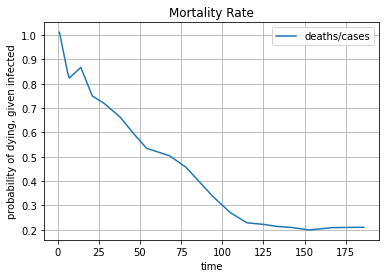

In [351]:
rate = who_data.iloc[:, 1]/who_data.iloc[:, 0]

plt.figure(figsize = [6, 4])
plt.plot(times, 100*rate, label = "deaths/cases")

plt.grid()
plt.legend()
plt.xlabel("time")
plt.ylabel("probability of dying, given infected")
plt.title("Mortality Rate")
plt.show()

This shows the deaths/cases as t increases. It's likely not too meaningful... but is levels off to be around 0.2% of the population

In [352]:
# code modified from https://towardsdatascience.com/estimating-parameters-of-compartmental-models-from-observed-data-62f87966bb2b
# initial guesses for parameters
alpha = 0.1
beta = 0.1

# other model parameters
initial_conditions = [S0, I0, R0]
num_days = 16
tspan = times[0:num_days]

# I'm sure there is a cleaner way to do this
data = np.concatenate((S_data[0:num_days], I_data[0:num_days], R_data[0:num_days]))

def error(params, initial_conditions, tspan, data):
    alpha, beta  = params['alpha'].value, params['beta'].value
    sol = np.array(odeint(SIR_model, initial_conditions, tspan, args=(alpha, beta)))
    sol_1d = np.concatenate((np.array(sol[:,0]),np.array(sol[:,1]),np.array(sol[:,2])))
    return (sol_1d - data)**2

params = Parameters()
params.add('beta', value=beta, min=0, max=10)
params.add('alpha', value=alpha, min=0, max=10)

result = minimize(error, params, args=(initial_conditions, tspan, data), method='leastsq')

result.params

name,value,standard error,relative error,initial value,min,max,vary
beta,0.04471543,5.9206e-04,(1.32%),0.1,0.00000000,10.0000000,True
alpha,0.01998280,6.6820e-04,(3.34%),0.1,0.00000000,10.0000000,True


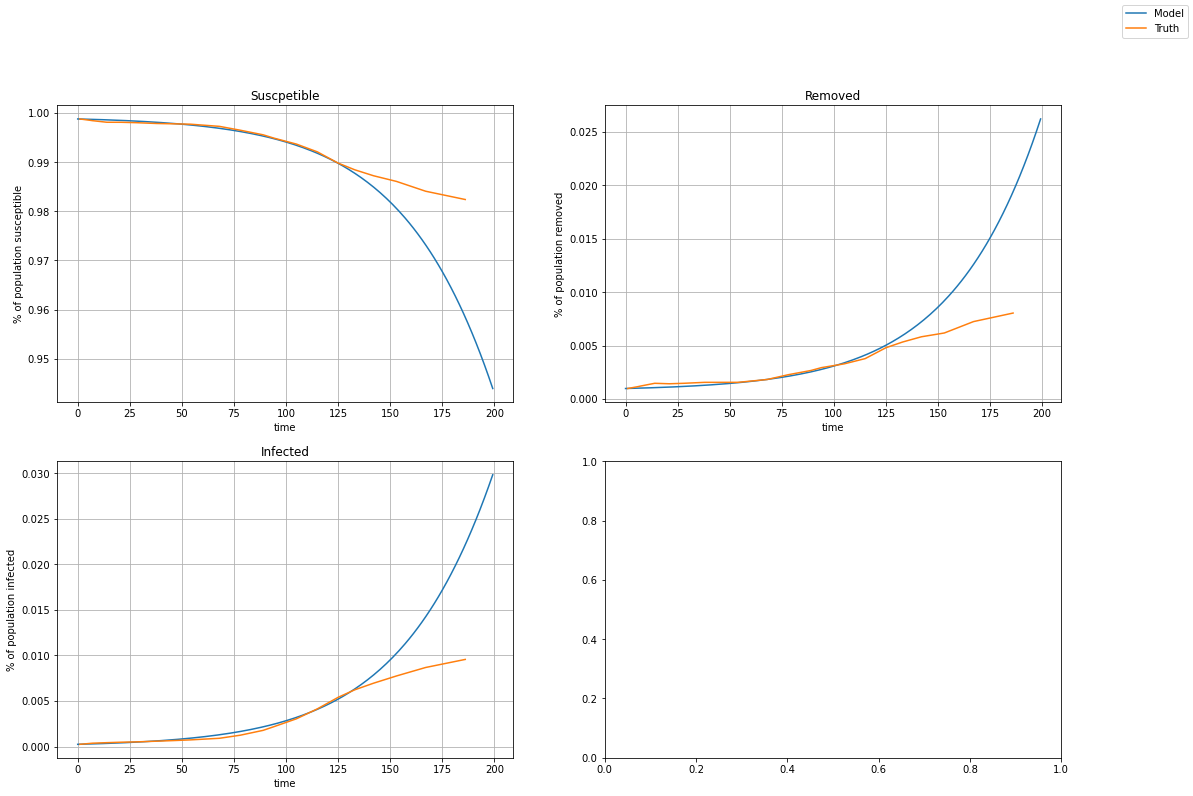

In [353]:
alpha = result.params['alpha'].value

beta = result.params['beta'].value

t = np.linspace(0, 1000, 1000)

sol = np.array(odeint(SIR_model, [S0, I0, R0], t, args=(alpha, beta)))
S_model = sol[:,0]
I_model = sol[:,1]
R_model = sol[:,2]

times[num_days]

sols = np.array(odeint(SIR_model, [S0, I0, R0], times, args=(alpha, beta)))
S_1 = sols[num_days,0]
I_1 = sols[num_days,1]
R_1 = sols[num_days,2]

# Start plotting
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
fig.set_figheight(12)
fig.set_figwidth(18)

# Plot susceptibles
ax1.plot(t[0:200], S_model[0:200], label = "Model")
ax1.plot(times, S_data, label = "Truth") 
ax1.grid()
ax1.set(xlabel="time", ylabel="% of population susceptible", title = "Suscpetible")

# Plot removed
ax2.plot(t[0:200], R_model[0:200])
ax2.plot(times, R_data) 
ax2.grid()
ax2.set(xlabel="time", ylabel="% of population removed", title = "Removed")

# Plot infected
ax3.plot(t[0:200], I_model[0:200])
ax3.plot(times, I_data) 
ax3.grid()
ax3.set(xlabel="time", ylabel="% of population infected", title = "Infected")

fig.legend()

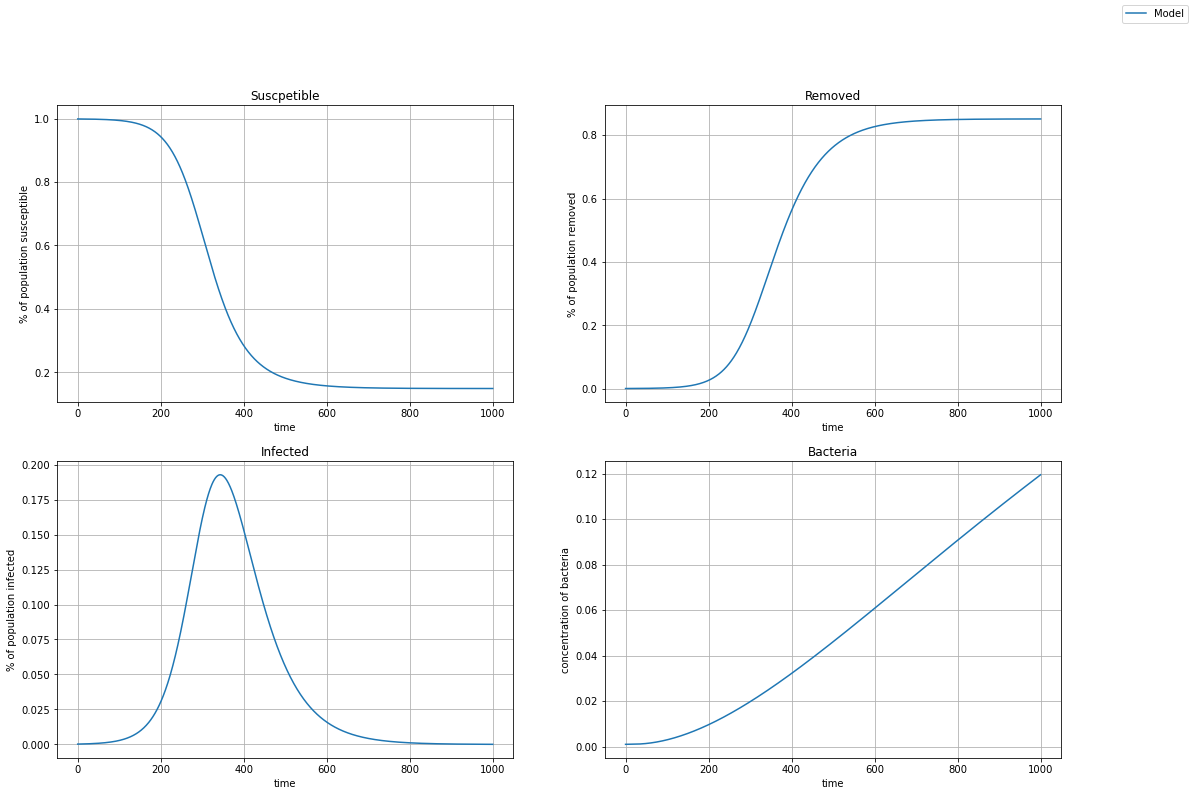

In [324]:
fig2, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
fig2.set_figheight(12)
fig2.set_figwidth(18)

# Plot susceptibles
ax1.plot(t, S_model, label = "Model")
ax1.grid()
ax1.set(xlabel="time", ylabel="% of population susceptible", title = "Suscpetible")

# Plot removed
ax2.plot(t, R_model)
ax2.grid()
ax2.set(xlabel="time", ylabel="% of population removed", title = "Removed")

# Plot infected
ax3.plot(t, I_model)
ax3.grid()
ax3.set(xlabel="time", ylabel="% of population infected", title = "Infected")

fig2.legend();

# model with water

In [343]:
# code modified from https://towardsdatascience.com/estimating-parameters-of-compartmental-models-from-observed-data-62f87966bb2b
# initial guesses for parameters
alpha = 0.1
beta = 0.01
beta2 = 0.3
beta3 = 0.1
beta4 = 0.1
beta5 = 0.1
k = 0.1

# other model parameters
initial_conditions = [S0, I0, R0, W0]
num_days = 20
tspan = times[0:num_days]

# I'm sure there is a cleaner way to do this
data = np.concatenate((S_data[0:num_days], I_data[0:num_days], R_data[0:num_days]))

def error(params, initial_conditions, tspan, data):
    alpha = params['alpha'].value
    # beta = params['beta'].value
    beta = 0
    beta2, beta3  = params['beta2'].value,  params['beta3'].value
    beta4, beta5, k = params['beta4'].value, params['beta5'].value, params['k'].value
    sol = np.array(odeint(SIR_model3, initial_conditions, tspan, args=(alpha, beta,beta2, beta3, beta4, beta5, k)))
    sol_1d = np.concatenate((np.array(sol[:,0]),np.array(sol[:,1]),np.array(sol[:,2])))
    return (sol_1d - data)**2

params = Parameters()
# params.add('beta', value=beta, min=0, max=10)
params.add('beta2', value=beta2, min=0, max=10)
params.add('beta3', value=beta3, min=0, max=10)
params.add('beta4', value=beta4, min=0, max=10)
params.add('beta5', value=beta5, min=0, max=10)
params.add('alpha', value=alpha, min=0, max=10)
params.add('k', value=alpha, min=0, max=10)

result = minimize(error, params, args=(initial_conditions, tspan, data), method='leastsq')

result.params
result

In [346]:
# Update paramters
alpha = result.params['alpha'].value
#beta = result.params['beta'].value
beta2 = result.params['beta2'].value
beta3 = result.params['beta3'].value
beta4 = result.params['beta4'].value
beta5 = result.params['beta5'].value
k = result.params['k'].value

t = np.linspace(0, 4000, 4000)

sol = np.array(odeint(SIR_model3, [S0, I0, R0, W0], t, args=(alpha, beta, beta2, beta3, beta4, beta5, k)))
S_model = sol[:,0]
I_model = sol[:,1]
R_model = sol[:,2]
W_model = sol[:,2]

times[num_days]

sols = np.array(odeint(SIR_model3, [S0, I0, R0, W0], times, args=(alpha, beta, beta2, beta3, beta4, beta5, k)))
S_1 = sols[0,0]
I_1 = sols[0,1]
R_1 = sols[0,2]
W_1 = sols[0,3]

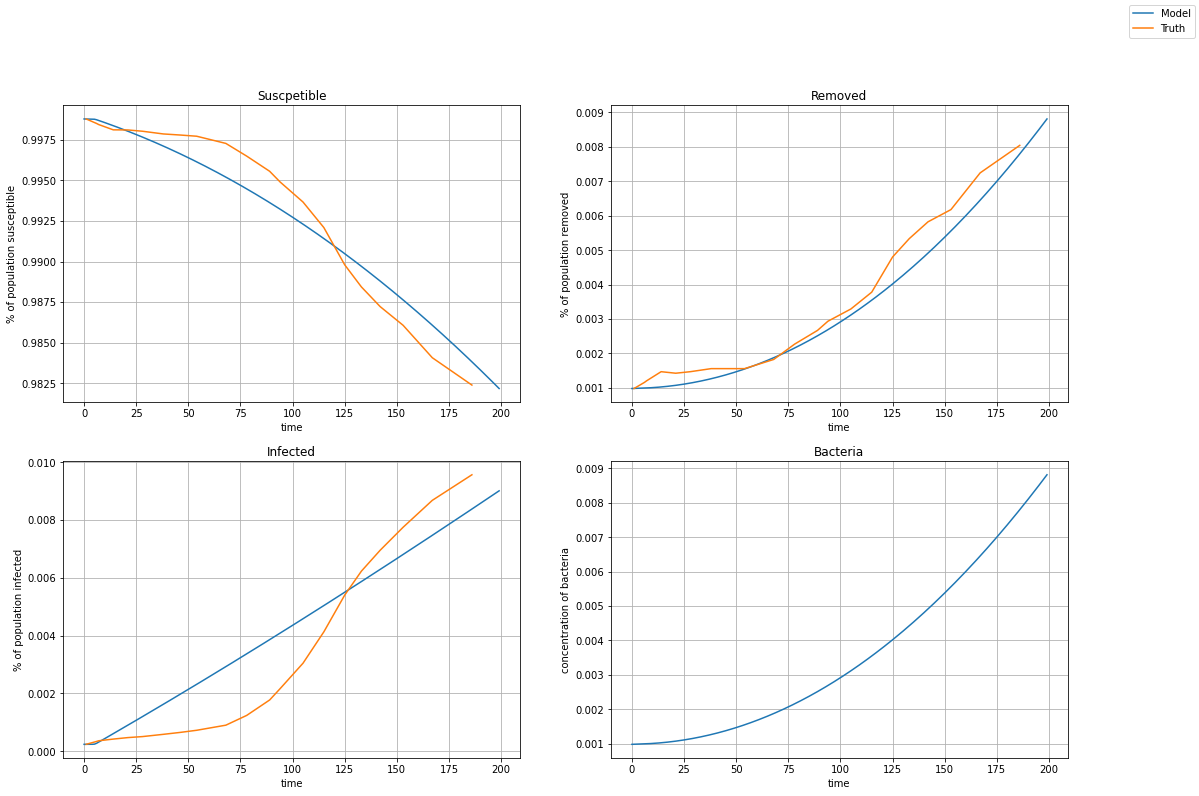

In [347]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
fig.set_figheight(12)
fig.set_figwidth(18)

# Plot susceptibles
ax1.plot(t[0:200], S_model[0:200], label = "Model")
ax1.plot(times, S_data, label = "Truth") 
ax1.grid()
ax1.set(xlabel="time", ylabel="% of population susceptible", title = "Suscpetible")

# Plot removed
ax2.plot(t[0:200], R_model[0:200])
ax2.plot(times, R_data) 
ax2.grid()
ax2.set(xlabel="time", ylabel="% of population removed", title = "Removed")

# Plot infected
ax3.plot(t[0:200], I_model[0:200])
ax3.plot(times, I_data) 
ax3.grid()
ax3.set(xlabel="time", ylabel="% of population infected", title = "Infected")

# Bacteria growth
ax4.plot(t[0:200], W_model[0:200])
ax4.grid()
ax4.set(xlabel="time", ylabel="concentration of bacteria", title = "Bacteria")

fig.legend()

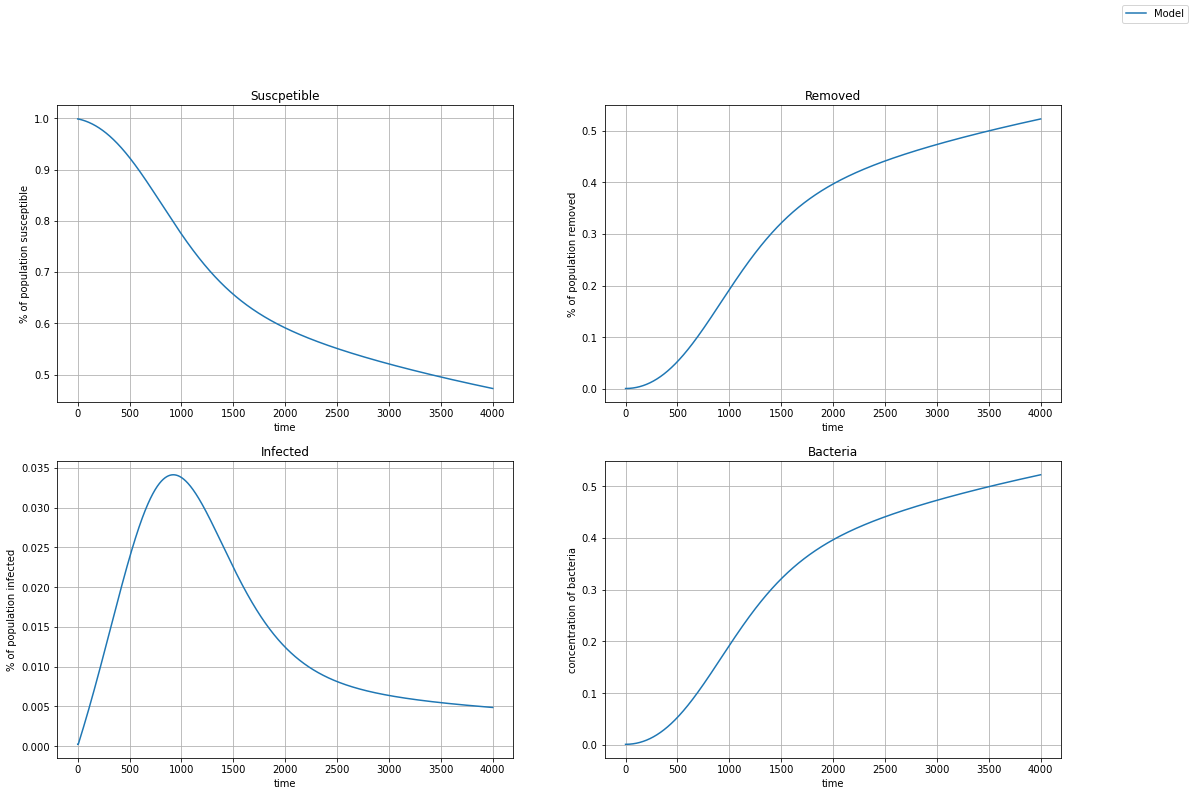

In [348]:
fig2, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
fig2.set_figheight(12)
fig2.set_figwidth(18)

# Plot susceptibles
ax1.plot(t, S_model, label = "Model")
ax1.grid()
ax1.set(xlabel="time", ylabel="% of population susceptible", title = "Suscpetible")

# Plot removed
ax2.plot(t, R_model)
ax2.grid()
ax2.set(xlabel="time", ylabel="% of population removed", title = "Removed")

# Plot infected
ax3.plot(t, I_model)
ax3.grid()
ax3.set(xlabel="time", ylabel="% of population infected", title = "Infected")

# Bacteria growth
ax4.plot(t, W_model)
ax4.grid()
ax4.set(xlabel="time", ylabel="concentration of bacteria", title = "Bacteria")

fig2.legend();

In [280]:
# Now control the water

# Update paramters
alpha = result.params['alpha'].value
beta = result.params['beta'].value
beta2 = result.params['beta2'].value
beta3 = 0 # result.params['beta3'].value
beta4 = 0 # result.params['beta4'].value
k = 0 # result.params['k'].value

t = np.linspace(0, 1000, 1000)

sol = np.array(odeint(SIR_model3, [S0, I0, R0, W0], t, args=(alpha, beta, beta2, beta3, beta4, k)))
S_model = sol[:,0]
I_model = sol[:,1]
R_model = sol[:,2]
W_model = sol[:,2]

times[num_days]

sols = np.array(odeint(SIR_model3, [S0, I0, R0, W0], times, args=(alpha, beta, beta2, beta3, beta4, k)))
S_1 = sols[0,0]
I_1 = sols[0,1]
R_1 = sols[0,2]
W_1 = sols[0,3]

TypeError: SIR_model3() missing 1 required positional argument: 'k'

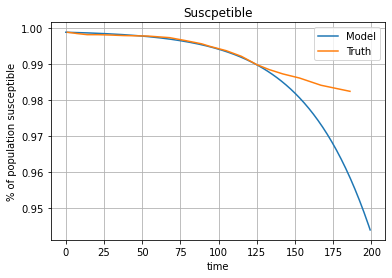

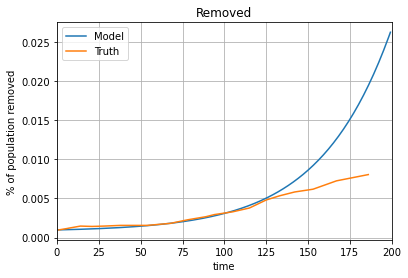

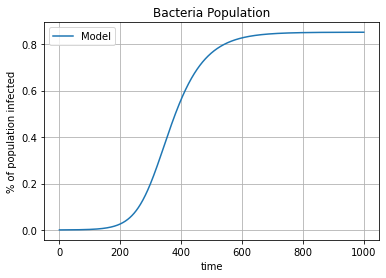

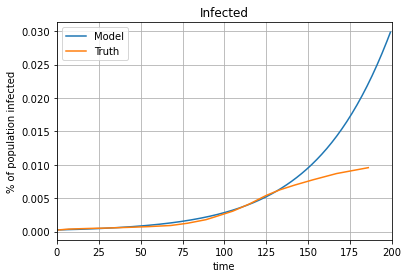

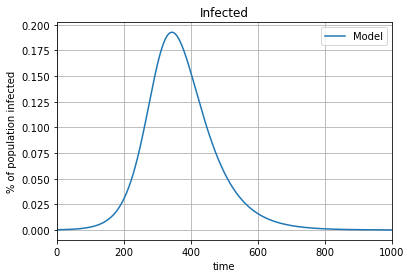

In [279]:

p = plt.figure(figsize = [6,4])

plt.plot(t[0:200], S_model[0:200], label = "Model")
plt.plot(times, S_data, label = "Truth") 

plt.grid()

# plt.plot([times[num_days]],[S_1],'ro', label = "control", markersize=6)
plt.legend()
plt.xlabel("time")
plt.ylabel("% of population susceptible")
plt.title("Suscpetible")
#plt.ylim(0.997,1)
plt.show()

# Plot removed
p = plt.figure(figsize = [6, 4])

plt.plot(t[0:200], R_model[0:200], label = "Model")
plt.plot(times, R_data, label = "Truth") 

plt.grid()
plt.legend()
plt.xlabel("time")
plt.ylabel("% of population removed")
plt.title("Removed")
plt.xlim(0,200)
plt.show()

# Bacteria growth
plt.figure(figsize = [6, 4])
# plt.plot(t[0:200], W_model[0:200], label = "Model")
plt.plot(t, W_model, label = "Model")
plt.grid()
plt.legend()
plt.xlabel("time")
plt.ylabel("% of population infected")
plt.title("Bacteria Population")
plt.show()


# Infected
plt.figure(figsize = [6, 4])
plt.plot(t[0:200], I_model[0:200], label = "Model")
plt.plot(times, I_data, label = "Truth")

# plt.plot(times,infected/N, label = "true infected")
plt.grid()
plt.legend()
plt.xlabel("time")
plt.ylabel("% of population infected")
plt.title("Infected")

#plt.ylim([0,0.005])
plt.xlim([0,200])
plt.show()

plt.figure(figsize = [6, 4])
plt.plot(t, I_model, label = "Model")

plt.grid()
plt.legend()
plt.xlabel("time")
plt.ylabel("% of population infected")
plt.title("Infected")

#plt.ylim([0,0.005])
plt.xlim([0,1000])
plt.show()

# Sources
Modeling Cholera Outbreaks
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4238032/

"Many cholera models assume that individuals become infected by consumption of V. cholerae from the environment and therefore include an explicit environmental compartment."

Modelling cholera epidemics: the role of waterways, human mobility and sanitation
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3243392/

[3] Prevention and control of cholera with household and community water, sanitation and hygiene (WASH) interventions: A scoping review of current international guidelines

DETERMINISTIC AND STOCHASTIC MODELS FOR
THE SPREAD OF CHOLERA


code modified from https://towardsdatascience.com/estimating-parameters-of-compartmental-models-from-observed-data-62f87966bb2b


# TODO
Diagram of compartment models used

Explain assumption and how they relate to the model

Explain terms in the model

For some reason, these parameters give good results

N = 100000

r_scale = 50.0

alpha = 0.001400102396391656 

beta = 0.03151161889949597

SIR model has a change in behaviour as beta- alpha goes from positive to negative.